### Chapt 11. 심층 신경망 훈련하기

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# 그래디언트 소실과 폭주 문제

def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


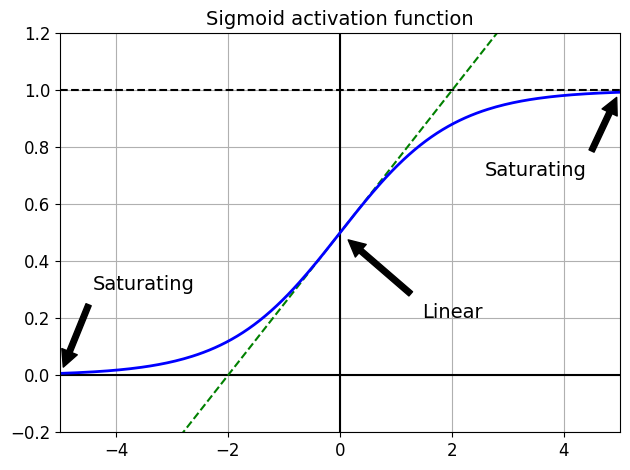

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [4]:
# Xavier 초기와와 He 초기화

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

In [7]:
# 수렴하지 않는 활성화 함수
# LeakyReLU

def leaky_relu(z, alpha=0):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


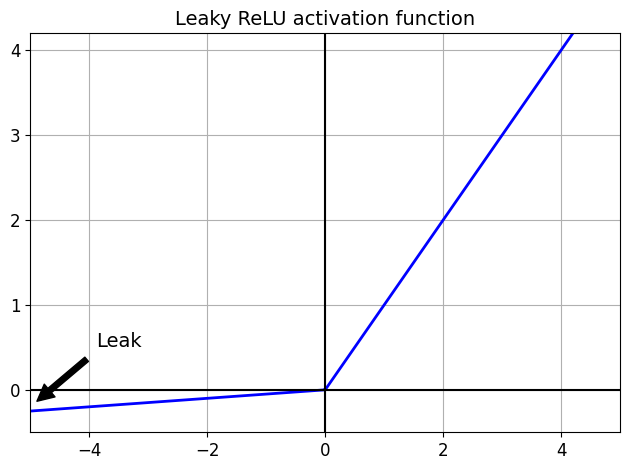

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)

props = dict(facecolor='black', shrink = 0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
# LeakyReLU, fashion MNIST, training

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2395 - accuracy: 0.6252 - val_loss: 0.8565 - val_accuracy: 0.7288
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7701 - accuracy: 0.7509 - val_loss: 0.6928 - val_accuracy: 0.7806
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6624 - accuracy: 0.7846 - val_loss: 0.6297 - val_accuracy: 0.7916
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6061 - accuracy: 0.8020 - val_loss: 0.5789 - val_accuracy: 0.8092
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5704 - accuracy: 0.8121 - val_loss: 0.5493 - val_accuracy: 0.8224
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5448 - accuracy: 0.8185 - val_loss: 0.5282 - val_accuracy: 0.8256
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5254 - accuracy: 0.8238 - val_loss: 0.5103 - val_accuracy:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3703 - accuracy: 0.5930 - val_loss: 0.9038 - val_accuracy: 0.7086
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8079 - accuracy: 0.7365 - val_loss: 0.7165 - val_accuracy: 0.7688
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6884 - accuracy: 0.7750 - val_loss: 0.6453 - val_accuracy: 0.7934
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6262 - accuracy: 0.7959 - val_loss: 0.5907 - val_accuracy: 0.8106
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5859 - accuracy: 0.8086 - val_loss: 0.5574 - val_accuracy: 0.8224
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5569 - accuracy: 0.8161 - val_loss: 0.5328 - val_accuracy: 0.8272
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5349 - accuracy: 0.8225 - val_loss: 0.5126 - val_accuracy:

In [18]:
# ELU

def elu(z, alpha=1):
    return np.where(z < 0, alpha*(np.exp(z) - 1), z)

그림 저장: elu_plot


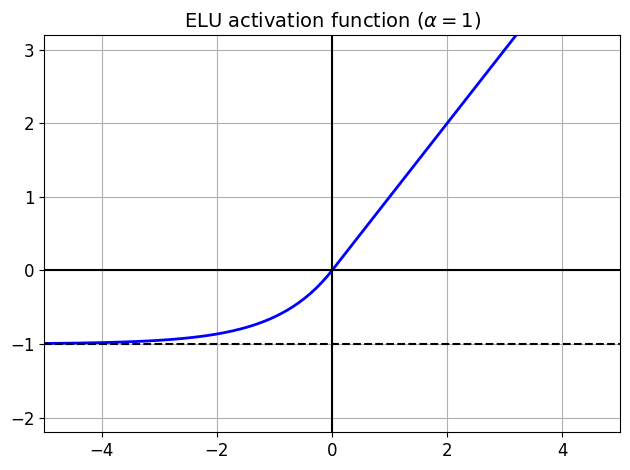

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [20]:
# 텐서플로에서 쉽게 ELU 적용, 층을 만들 때 활성화 함수로 지정

keras.layers.Dense(10, activation="elu")

In [21]:
# SELU

from scipy.special import erfc

# alpha와 scale은 평균 0과 표준편차 1로 자기 정규화한다

alpha_0_1 = -np.sqrt(2/np.pi) / (erfc(1/np.sqrt(2))*np.exp(1/2)-1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale = scale_0_1, alpha=alpha_0_1):
    return scale*elu(z, alpha)

그림 저장: selu_plot


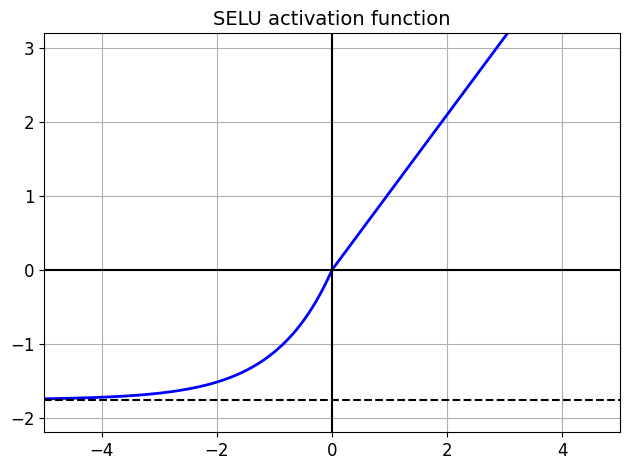

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [ ]:
# SELU 하이퍼파라미터 각 뉴런의 평균 출력이 0에 가까움, 표준편차는 1에 가깝도록 조정됨 (입력은 평균0, 표준편차 1로 표준화되었다고 가정)
# 이 활성화함수를 사용하면 1000개의 층이 있는 심층 긴경망도 모든 층에 걸쳐 거의 평균 0이 되고 표준편차를 1로 유지
# 이를 통해 그레디언트 폭주와 소실문제 피할 수 있음

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [26]:
keras.layers.Dense(10, activation="selu", kernel_initializer = "lecun_normal")

In [27]:
# 100 hidden layers using SELU, fashion MNIST

np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])


In [33]:
# Training, input mean 0, sd 1

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 58s 32ms/step - loss: 1.2002 - accuracy: 0.5405 - val_loss: 0.8142 - val_accuracy: 0.6914
Epoch 2/5
1719/1719 [==============================] - 54s 32ms/step - loss: 0.7545 - accuracy: 0.7266 - val_loss: 0.6555 - val_accuracy: 0.7662
Epoch 3/5
1719/1719 [==============================] - 51s 30ms/step - loss: 0.6541 - accuracy: 0.7629 - val_loss: 0.6604 - val_accuracy: 0.7686
Epoch 4/5
1719/1719 [==============================] - 51s 30ms/step - loss: 0.5870 - accuracy: 0.7886 - val_loss: 0.5160 - val_accuracy: 0.8138
Epoch 5/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.5414 - accuracy: 0.8088 - val_loss: 0.4925 - val_accuracy: 0.8272


In [35]:
# Use ReLU instead

np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

In [38]:
history  = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data = (X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 59s 33ms/step - loss: 2.0288 - accuracy: 0.2131 - val_loss: 1.8476 - val_accuracy: 0.2964
Epoch 2/5
1719/1719 [==============================] - 56s 32ms/step - loss: 1.6902 - accuracy: 0.3386 - val_loss: 1.3611 - val_accuracy: 0.4318
Epoch 3/5
1719/1719 [==============================] - 56s 33ms/step - loss: 1.3362 - accuracy: 0.4584 - val_loss: 1.2361 - val_accuracy: 0.5384
Epoch 4/5
1719/1719 [==============================] - 56s 32ms/step - loss: 1.0626 - accuracy: 0.5638 - val_loss: 0.8944 - val_accuracy: 0.6428
Epoch 5/5
1719/1719 [==============================] - 56s 33ms/step - loss: 0.8831 - accuracy: 0.6508 - val_loss: 0.7981 - val_accuracy: 0.6732


In [40]:
# Batch Normalarlization

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])


In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [43]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [44]:
# updates 속성은 향후 삭제됨
# bn1.updates

In [45]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(learning_rate=1e-3),
             metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8461 - accuracy: 0.7159 - val_loss: 0.5521 - val_accuracy: 0.8114
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5684 - accuracy: 0.8039 - val_loss: 0.4720 - val_accuracy: 0.8374
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5140 - accuracy: 0.8234 - val_loss: 0.4391 - val_accuracy: 0.8468
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4783 - accuracy: 0.8337 - val_loss: 0.4165 - val_accuracy: 0.8558
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4525 - accuracy: 0.8425 - val_loss: 0.3996 - val_accuracy: 0.8614
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4367 - accuracy: 0.8474 - val_loss: 0.3892 - val_accuracy: 0.8662
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4236 - accuracy: 0.8512 - val_loss: 0.3778 - val_ac

In [ ]:
# 이따끔 활성화 함수 전에 BN을 적용해도 잘 작동함
# BatchNormalization 층 이전의 층은 편향을 위한 항이 필요 없다 -> BatchNormalization 층이 무효화하기 때문
# 필요없는 파라미터이므로 use_bias=False 지정하여 층을 만들 수 있다

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [48]:
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.SGD(learning_rate=1e-3), metrics =["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0368 - accuracy: 0.6804 - val_loss: 0.6643 - val_accuracy: 0.7882
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6737 - accuracy: 0.7835 - val_loss: 0.5460 - val_accuracy: 0.8250
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5930 - accuracy: 0.8047 - val_loss: 0.4926 - val_accuracy: 0.8412
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5441 - accuracy: 0.8185 - val_loss: 0.4598 - val_accuracy: 0.8494
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5113 - accuracy: 0.8273 - val_loss: 0.4392 - val_accuracy: 0.8540
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4901 - accuracy: 0.8329 - val_loss: 0.4225 - val_accuracy: 0.8572
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4722 - accuracy: 0.8403 - val_loss: 0.4094 - val_ac

In [ ]:
# Gradient Clipping
# 모든 케라스 옴티마이저는 clipnorm이나 clipvalud 매개변수를 지원한다

In [52]:
optimizer = keras.optimizers.SGD(clipvalue = 1.0)

In [53]:
optimizer = keras.optimizers.SGD(clipnorm = 1.0)

In [ ]:
# 사전 훈련된 층 재사용하기
# 케라스 모델 재사용하기

In [54]:
def split_dataset(X, y):
    y_5_or_6 = (y==6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt? class 6?
    return ((X[~y_5_or_6], y_A),
           (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]


In [55]:
X_train_A.shape

(49493, 28, 28)

In [56]:
X_train_B.shape

(200, 28, 28)

In [57]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 5, 5], dtype=uint8)

In [58]:
y_train_B[:30]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

In [60]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [66]:
model_A.compile(loss = "sparse_categorical_crossentropy",
               optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
               metrics = ["accuracy"])

In [67]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data = (X_valid_A, y_valid_A))

Epoch 1/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.5350 - accuracy: 0.8207 - val_loss: 0.3600 - val_accuracy: 0.8775
Epoch 2/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.3331 - accuracy: 0.8844 - val_loss: 0.3094 - val_accuracy: 0.8926
Epoch 3/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2992 - accuracy: 0.8958 - val_loss: 0.2895 - val_accuracy: 0.9008
Epoch 4/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2818 - accuracy: 0.9020 - val_loss: 0.2792 - val_accuracy: 0.9055
Epoch 5/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2700 - accuracy: 0.9057 - val_loss: 0.2711 - val_accuracy: 0.9044
Epoch 6/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2615 - accuracy: 0.9094 - val_loss: 0.2674 - val_accuracy: 0.9068
Epoch 7/20
1547/1547 [==============================] - 6s 4ms/step - loss: 0.2546 - accuracy: 0.9119 - val_loss: 0.2573 - val_accuracy:

In [68]:
model_A.save("my_model_A.h5")

In [71]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [72]:
model_B.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

In [73]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 32ms/step - loss: 0.3943 - accuracy: 0.8150 - val_loss: 0.0882 - val_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0676 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0425 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 8/20
7/7 [===========

In [74]:
model_B.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_230 (Dense)           (None, 300)               235500    
                                                                 
 dense_231 (Dense)           (None, 100)               30100     
                                                                 
 dense_232 (Dense)           (None, 50)                5050      
                                                                 
 dense_233 (Dense)           (None, 50)                2550      
                                                                 
 dense_234 (Dense)           (None, 50)                2550      
                                                                 
 dense_235 (Dense)           (None, 1)                

In [75]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# model_B_on_A와 model_A는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트됨. 
# 이를 피하려면 model_A를 클론한 것을 사용해 model_B_on_A를 만들어야 한다

In [77]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [78]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", optimizer = keras.optimizers.SGD(learning_rate=1e-3),
                    metrics = ["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data = (X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 33ms/step - loss: 0.0972 - accuracy: 0.9950 - val_loss: 0.1084 - val_accuracy: 0.9858
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.0941 - accuracy: 0.9950 - val_loss: 0.1051 - val_accuracy: 0.9858
Epoch 3/4
7/7 [==============================] - 0s 13ms/step - loss: 0.0912 - accuracy: 0.9950 - val_loss: 0.1021 - val_accuracy: 0.9858
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.0885 - accuracy: 0.9950 - val_loss: 0.0993 - val_accuracy: 0.9878


In [79]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy", optimizer = keras.optimizers.SGD(learning_rate=1e-3),
                    metrics = ["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data = (X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 32ms/step - loss: 0.0737 - accuracy: 0.9950 - val_loss: 0.0657 - val_accuracy: 0.9959
Epoch 2/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0516 - accuracy: 0.9950 - val_loss: 0.0498 - val_accuracy: 0.9959
Epoch 3/16
7/7 [==============================] - 0s 13ms/step - loss: 0.0404 - accuracy: 0.9950 - val_loss: 0.0404 - val_accuracy: 0.9980
Epoch 4/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0336 - accuracy: 0.9950 - val_loss: 0.0342 - val_accuracy: 0.9980
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0288 - accuracy: 0.9950 - val_loss: 0.0296 - val_accuracy: 0.9980
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0253 - accuracy: 0.9950 - val_loss: 0.0262 - val_accuracy: 0.9980
Epoch 7/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.0235 - val_accuracy: 0.9980
Epoch 8/16
7/7 [===========

In [80]:
model_B.evaluate(X_test_B, y_test_B)

32/32 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 1.0000


[0.009162602946162224, 1.0]

In [82]:
model_B_on_A.evaluate(X_test_B, y_test_B)

32/32 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000


[0.011694206856191158, 1.0]

In [83]:
(100 - 97.05) / (100 - 99.40) ## 1.0으로 나와서 오차율이 차이가 없음

4.916666666666718

In [ ]:
# 고속 옵티마이저
## 모멘텀 옵티마이저

In [85]:
optimizer = keras.optimizers.SGD(learning_rate = 0.001, momentum=0.9)

In [86]:
# 네스테로프 가속 경사

optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [87]:
# Adagrad

optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [88]:
# RMSprop

optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [89]:
# Adam optimizer

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [90]:
# Adamax optimizer

optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [91]:
# Nadam optimizer

optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
# 학습률 스케줄링
# 거듭제곱 스케줄링
# lr = lr0 / (1 + steps / s)**c
# 케라스는 c=1과 s = 1 / decay을 사용합니다

In [92]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])

In [94]:
n_epochs = 24
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data = (X_valid_scaled, y_valid))

Epoch 1/24
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4935 - accuracy: 0.8243 - val_loss: 0.4110 - val_accuracy: 0.8596
Epoch 2/24
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3832 - accuracy: 0.8649 - val_loss: 0.3780 - val_accuracy: 0.8662
Epoch 3/24
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3498 - accuracy: 0.8753 - val_loss: 0.3807 - val_accuracy: 0.8656
Epoch 4/24
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3280 - accuracy: 0.8829 - val_loss: 0.3549 - val_accuracy: 0.8770
Epoch 5/24
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3128 - accuracy: 0.8891 - val_loss: 0.3502 - val_accuracy: 0.8738
Epoch 6/24
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2989 - accuracy: 0.8942 - val_loss: 0.3490 - val_accuracy: 0.8762
Epoch 7/24
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2890 - accuracy: 0.8973 - val_loss: 0.3432 - val_accuracy:

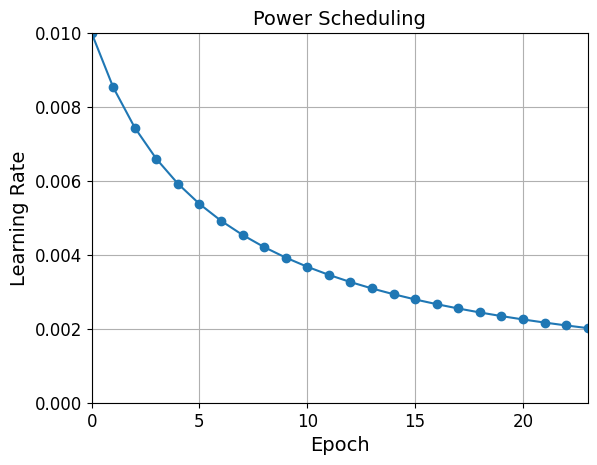

In [97]:
import math

learning_rate = 0.01
decay=1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay*epochs*n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize = 14)
plt.grid(True)
plt.show()

In [ ]:
# 지수 기반 스케줄링
# lr = lr0 * 0.1**(epoch / s)

In [98]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [99]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [100]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [101]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9072 - accuracy: 0.7427 - val_loss: 1.0134 - val_accuracy: 0.7262 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7345 - accuracy: 0.7871 - val_loss: 0.6170 - val_accuracy: 0.8188 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6217 - accuracy: 0.8188 - val_loss: 0.6375 - val_accuracy: 0.8168 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5625 - accuracy: 0.8306 - val_loss: 0.5786 - val_accuracy: 0.8400 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5023 - accuracy: 0.8485 - val_loss: 0.5365 - val_accuracy: 0.8574 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4597 - accuracy: 0.8614 - val_loss: 0.5516 - val_accuracy: 0.8556 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

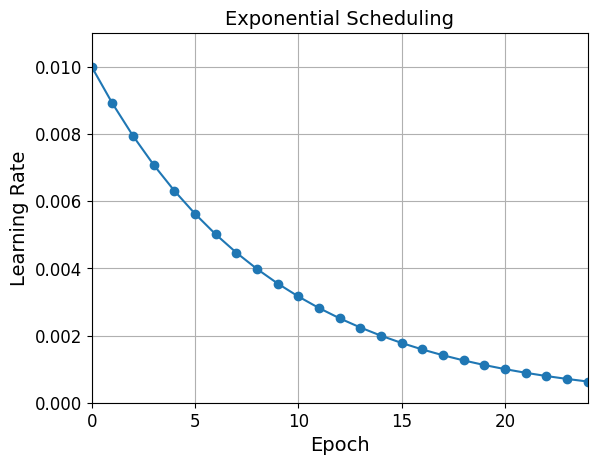

In [102]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [103]:
# 이 스케줄 함수는 두번째 매개변수로 현재 학습률을 받을 수 있다

def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [104]:
# 에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 한다

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8212 - accuracy: 0.7617 - val_loss: 0.7450 - val_accuracy: 0.7514 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6519 - accuracy: 0.8039 - val_loss: 0.5320 - val_accuracy: 0.8074 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5747 - accuracy: 0.8243 - val_loss: 0.6925 - val_accuracy: 0.7802 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5290 - accuracy: 0.8355 - val_loss: 0.4667 - val_accuracy: 0.8452 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4675 - accuracy: 0.8524 - val_loss: 0.4917 - val_accuracy: 0.8566 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4350 - accuracy: 0.8638 - val_loss: 0.4779 - val_accuracy: 0.8616 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [105]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

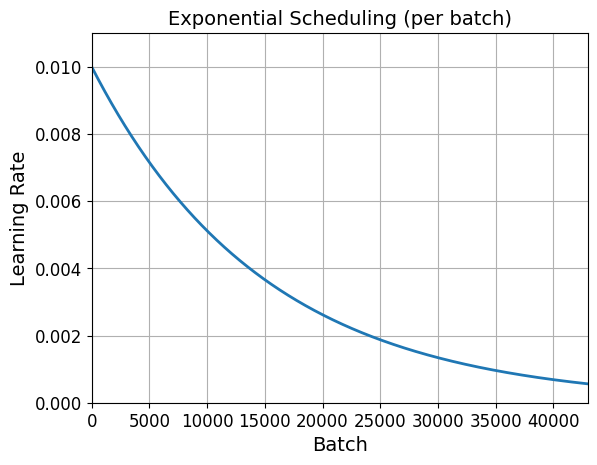

In [106]:

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

In [107]:
# 기간별 고정 스케줄링

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [108]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [109]:

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8985 - accuracy: 0.7465 - val_loss: 1.1739 - val_accuracy: 0.6968 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9344 - accuracy: 0.7326 - val_loss: 1.0583 - val_accuracy: 0.6614 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8550 - accuracy: 0.7499 - val_loss: 0.9759 - val_accuracy: 0.6812 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7711 - accuracy: 0.7670 - val_loss: 1.0501 - val_accuracy: 0.7078 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9635 - accuracy: 0.7005 - val_loss: 0.9661 - val_accuracy: 0.6812 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5820 - accuracy: 0.8097 - val_loss: 0.6510 - val_accuracy: 0.8310 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

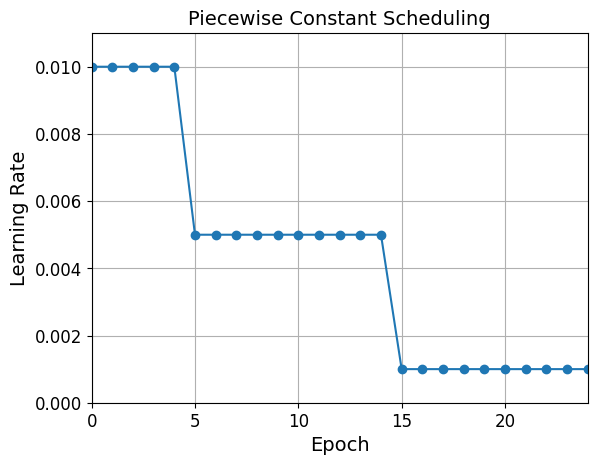

In [110]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [111]:
# 성능 기반 스케줄링

tf.random.set_seed(42)
np.random.seed(42)

In [112]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5875 - accuracy: 0.8077 - val_loss: 0.4544 - val_accuracy: 0.8558 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4988 - accuracy: 0.8396 - val_loss: 0.5582 - val_accuracy: 0.8456 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5166 - accuracy: 0.8425 - val_loss: 0.5484 - val_accuracy: 0.8534 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5029 - accuracy: 0.8479 - val_loss: 0.4985 - val_accuracy: 0.8454 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5308 - accuracy: 0.8485 - val_loss: 0.5285 - val_accuracy: 0.8392 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5002 - accuracy: 0.8550 - val_loss: 0.5343 - val_accuracy: 0.8662 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 4s

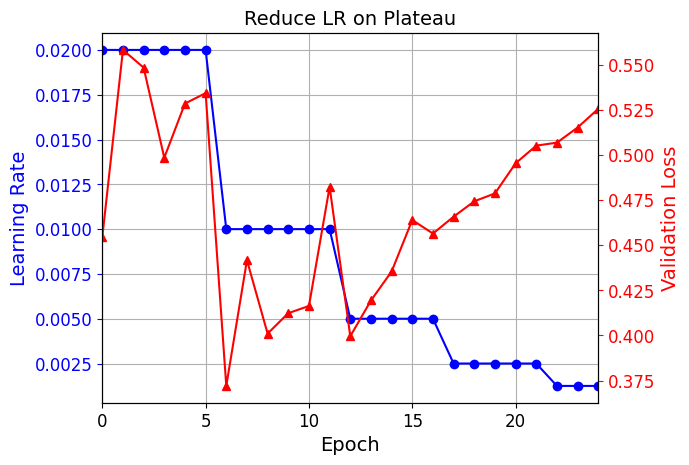

In [113]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [114]:
# tf.keras 스케줄러

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4903 - accuracy: 0.8275 - val_loss: 0.4045 - val_accuracy: 0.8548
Epoch 2/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3821 - accuracy: 0.8653 - val_loss: 0.3723 - val_accuracy: 0.8688
Epoch 3/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3486 - accuracy: 0.8761 - val_loss: 0.3736 - val_accuracy: 0.8676
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3267 - accuracy: 0.8831 - val_loss: 0.3514 - val_accuracy: 0.8770
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3111 - accuracy: 0.8897 - val_loss: 0.3440 - val_accuracy: 0.8772
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2966 - accuracy: 0.8938 - val_loss: 0.3405 - val_accuracy: 0.8802
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2863 - accuracy: 0.8989 - val_loss: 0.3362 - val_accuracy:

In [115]:
# 구간별 고정 스케줄링

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

In [116]:
# 1 사이클 스케줄링

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [117]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.3937                    


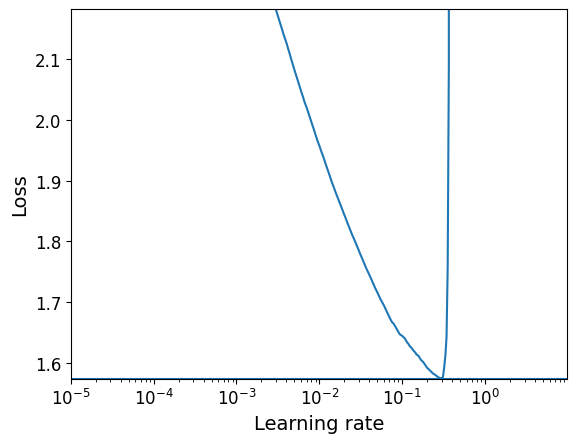

In [118]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [119]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [120]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6471 - accuracy: 0.7751 - val_loss: 0.4862 - val_accuracy: 0.8310
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4585 - accuracy: 0.8389 - val_loss: 0.4312 - val_accuracy: 0.8510
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4141 - accuracy: 0.8532 - val_loss: 0.4119 - val_accuracy: 0.8566
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3856 - accuracy: 0.8628 - val_loss: 0.3889 - val_accuracy: 0.8636
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3649 - accuracy: 0.8702 - val_loss: 0.3773 - val_accuracy: 0.8642
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3456 - accuracy: 0.8754 - val_loss: 0.3725 - val_accuracy: 0.8716
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8803 - val_loss: 0.3588 - val_accuracy: 0.8758
Epoch 

In [121]:
# 규제를 사용해 과대적합 피하기

layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively


In [122]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 1.6430 - accuracy: 0.8107 - val_loss: 0.7214 - val_accuracy: 0.8314
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7198 - accuracy: 0.8271 - val_loss: 0.6816 - val_accuracy: 0.8398


In [123]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 1.7176 - accuracy: 0.8123 - val_loss: 0.7142 - val_accuracy: 0.8334
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7171 - accuracy: 0.8289 - val_loss: 0.6815 - val_accuracy: 0.8402


In [124]:
# 드롭아웃

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5741 - accuracy: 0.8014 - val_loss: 0.3657 - val_accuracy: 0.8664
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4205 - accuracy: 0.8456 - val_loss: 0.3361 - val_accuracy: 0.8764


In [125]:
# 알파 드롭아웃

tf.random.set_seed(42)
np.random.seed(42)

In [126]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6627 - accuracy: 0.7603 - val_loss: 0.6012 - val_accuracy: 0.8434
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5557 - accuracy: 0.7963 - val_loss: 0.5631 - val_accuracy: 0.8422
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5226 - accuracy: 0.8064 - val_loss: 0.4969 - val_accuracy: 0.8548
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5037 - accuracy: 0.8132 - val_loss: 0.4649 - val_accuracy: 0.8628
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4904 - accuracy: 0.8173 - val_loss: 0.4433 - val_accuracy: 0.8664
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4809 - accuracy: 0.8218 - val_loss: 0.4703 - val_accuracy: 0.8606
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4700 - accuracy: 0.8258 - val_loss: 0.4723 - val_accuracy:

In [127]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4419 - accuracy: 0.8624


[0.44188305735588074, 0.8623999953269958]

In [128]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3297 - accuracy: 0.8851


[0.32968562841415405, 0.8851454257965088]

In [129]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.4189 - accuracy: 0.8448


In [130]:
# MC 드롭아웃

tf.random.set_seed(42)
np.random.seed(42)

In [131]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [132]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 88ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]],
      dtype=float32)

In [133]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.03, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.13, 0.  , 0.86]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.04, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.41, 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.29, 0.  , 0.22]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.47, 0.  , 0.1 , 0.  , 0.43]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.01, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.55, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.06, 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.68, 0.  , 0.03, 0.  , 0.29]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.24, 0.  , 0.44]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.9 , 0.  , 0.  , 0.  , 0.1 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.08, 0.  , 0

In [134]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.23, 0.02, 0.29]],
      dtype=float32)

In [135]:
y_pred = np.argmax(y_proba, axis=1)

In [136]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8683

In [137]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [138]:
tf.random.set_seed(42)
np.random.seed(42)

In [139]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [140]:
mc_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_269 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_270 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [141]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [142]:
mc_model.set_weights(model.get_weights())

In [143]:

np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 15ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.2 , 0.  , 0.63]],
      dtype=float32)

In [144]:
# 맥스 노름

In [145]:

layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [146]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4823 - accuracy: 0.8297 - val_loss: 0.3691 - val_accuracy: 0.8670
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3554 - accuracy: 0.8709 - val_loss: 0.3692 - val_accuracy: 0.8680
